In [1]:
import os
import time

import tensorflow as tf
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor

%matplotlib inline

print(f"TensorFlow (v{tf.version.VERSION})")
try:
    physical_device = tf.config.list_physical_devices('GPU')[0]
    print(f"GPU device: {physical_device.name}")
    tf.config.experimental.set_memory_growth(physical_device, True)
except:
    print("Invalid device or cannot modify virtual devices once initialized. Device name {}".format(
        physical_device.name
    ))
    pass

TensorFlow (v2.6.0)
GPU device: /physical_device:GPU:0


In [2]:
def load_image(filename):
    raw = tf.io.read_file(filename)
    image = tf.image.decode_png(raw, channels=3)
    return image

In [3]:
def random_augment(image, factor=0.3):

    def random_perspective(image):
        theta = tf.random.uniform([1], minval=-15, maxval=16, dtype=tf.dtypes.int32).numpy()[0]
        tx = tf.random.uniform((1, ), minval=-30, maxval=31, dtype=tf.dtypes.int32).numpy()[0]
        ty = tf.random.uniform((1, ), minval=-30, maxval=31, dtype=tf.dtypes.int32).numpy()[0]
        shear = tf.random.uniform([1], minval=-15, maxval=16, dtype=tf.dtypes.int32).numpy()[0]
        zx = tf.random.uniform((1, ), minval=0.7, maxval=1.0).numpy()[0]
        zy = tf.random.uniform((1, ), minval=0.7, maxval=1.0).numpy()[0]
        perspective = tf.keras.preprocessing.image.apply_affine_transform(
            image, theta, tx, ty, shear, zx, zx,
            row_axis=0, col_axis=1, channel_axis=2
        )
        return perspective  
    
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_brightness(image, 0.08).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_contrast(image, 0.7, 1.0).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_saturation(image, 0.7, 1.0).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_flip_left_right(image).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_flip_up_down(image).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_hue(image, 0.1).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_jpeg_quality(image, 5, 100).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.keras.preprocessing.image.random_rotation(image, 45, row_axis=0, col_axis=1, channel_axis=2)
    if tf.random.normal([1]) > 0.5:
        image = random_perspective(image)
    return image

In [5]:
def get_labeled_image(filepath):
    image = load_image(filepath)
    label = tf.strings.split(filepath, sep=' ')[0]
    label = tf.strings.split(label, sep=os.sep)[-1]
    label = tf.strings.to_number(label, out_type=tf.int32) - 1
    return image, label

In [6]:
def get_files(root):
    PATHS = list()

    def parse_dir(root):
        if os.path.isfile(root):
            PATHS.append(root)
        elif os.path.isdir(root):
            for dirname in os.listdir(root):
                parse_dir(os.path.join(root, dirname))

    parse_dir(root)
    return PATHS

In [7]:
IMAGE_PATHS = get_files('icons')
print('\n'.join(IMAGE_PATHS))

icons\1 — Test.png
icons\10 — Cap.png
icons\2 — Medal.png
icons\3 — PC.png
icons\4 — Search.png
icons\5 — Projector.png
icons\6 — Idea.png
icons\7 — Telescope.png
icons\8 — Briefcase.png
icons\9 — Trofy.png


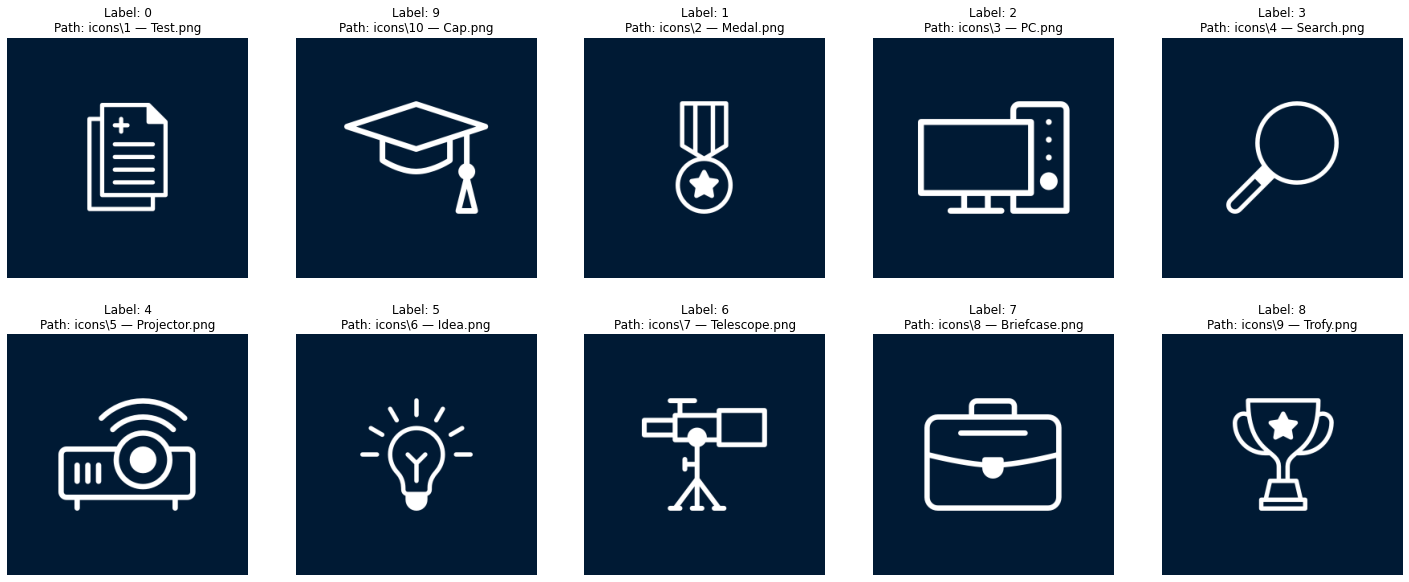

In [7]:
plt.figure(figsize=(25, 10))
for i, path in enumerate(IMAGE_PATHS):
    image, label = get_labeled_image(path)

    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"Label: {label}\nPath: {path}")
    plt.axis('off')

plt.show()

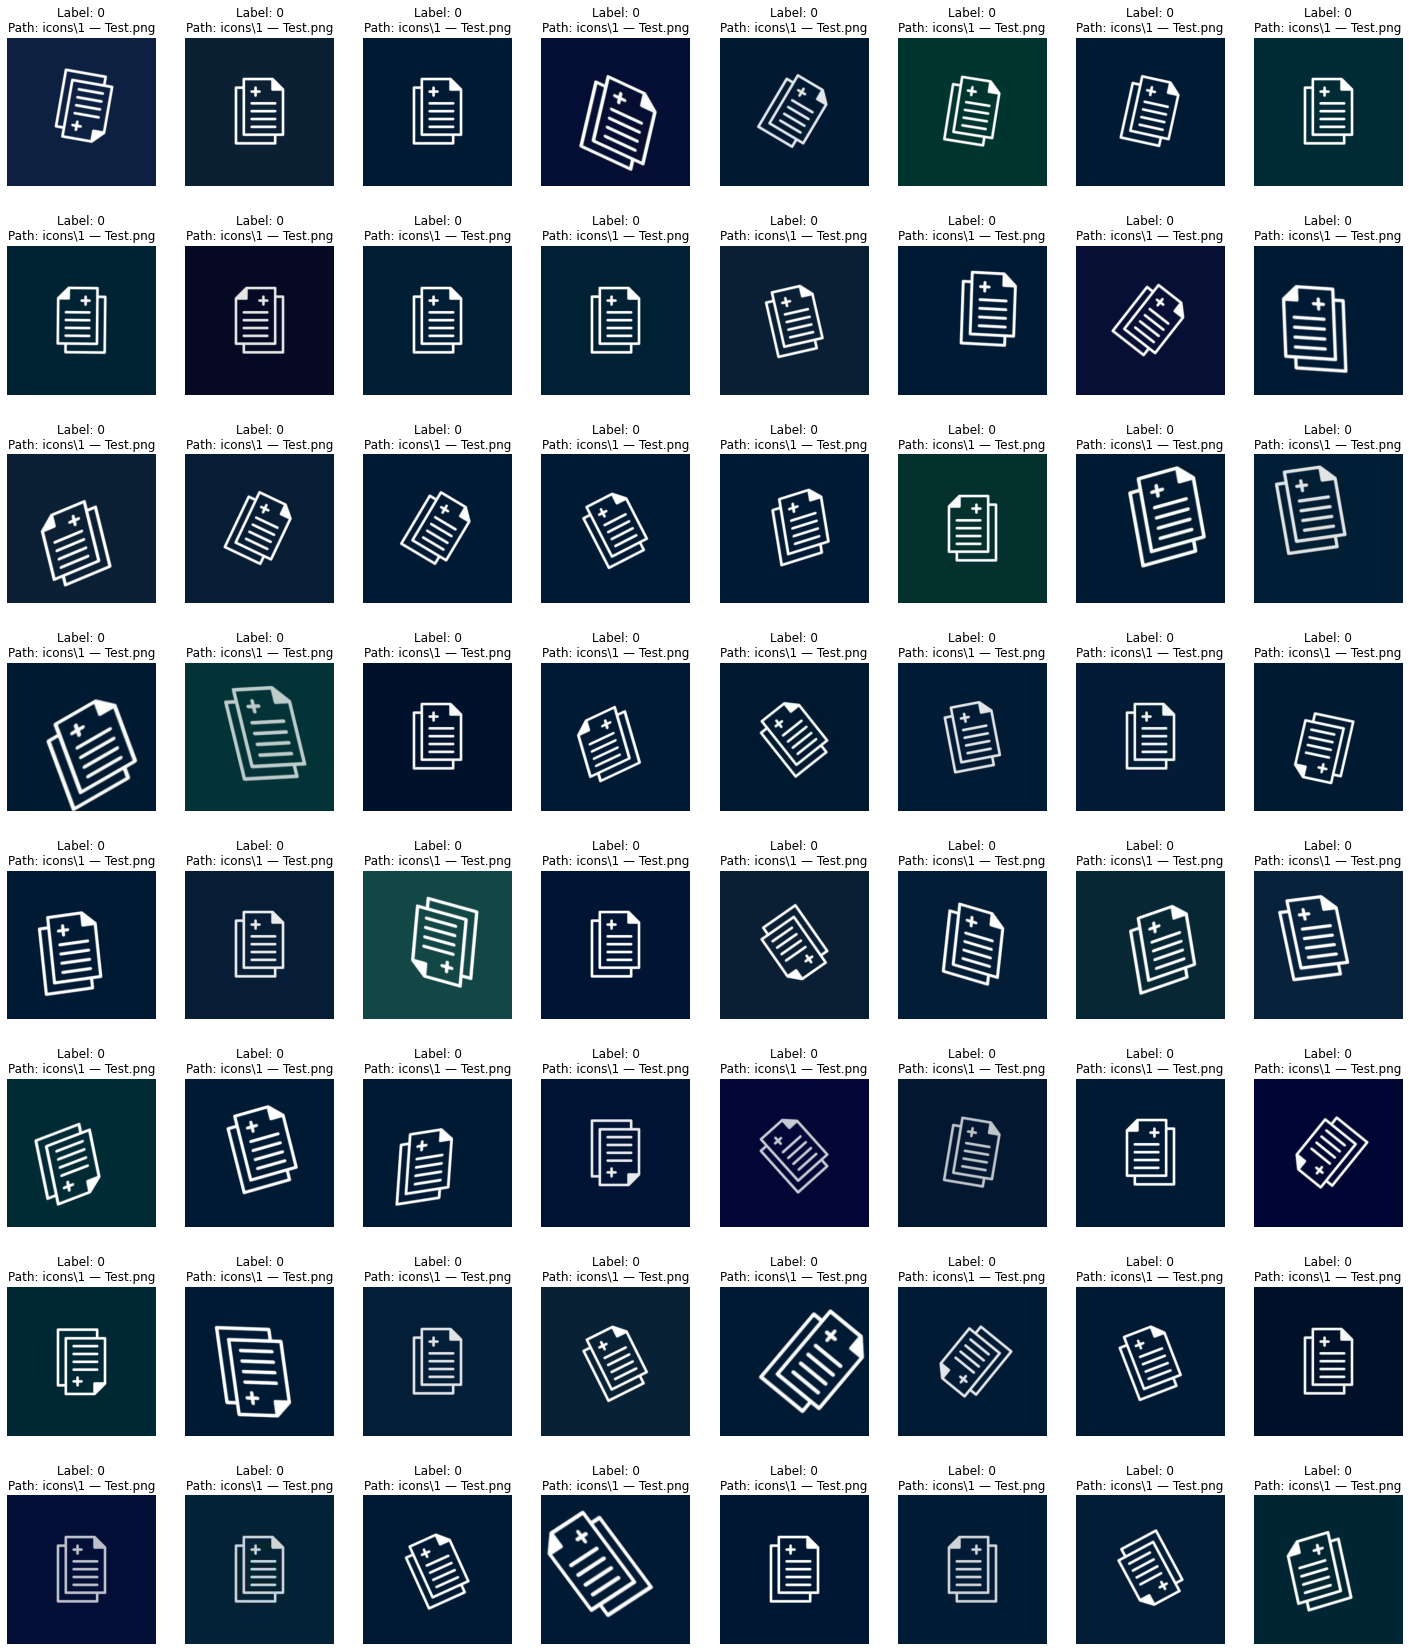

In [14]:
plt.figure(figsize=(25, 30))
for i, path in enumerate([IMAGE_PATHS[0]] * 64):
    image, label = get_labeled_image(path)
    # image = tf.image.convert_image_dtype()
    image = random_augment(image.numpy())

    plt.subplot(8, 8, i+1)
    plt.imshow(image)
    plt.title(f"Label: {label}\nPath: {path}")
    plt.axis('off')

plt.show()

In [8]:
def get_datasets(paths, num_repeats=100, target_size=None, train_split=0.7):

    def _get_augmented_image(path):
        image, label = get_labeled_image(path)
        image = tf.cast(image, tf.dtypes.float32) / 255.
        image = random_augment(image.numpy())
        return [image, label]


    images = list()
    labels = list()
    data = list()

    paths = tf.random.shuffle(tf.repeat(paths, num_repeats))
    size = len(paths)
    
    with ThreadPoolExecutor(32) as pool:
        data = list(pool.map(_get_augmented_image, paths))

    for x, y in data:
        images.append(x)
        labels.append(y)

    train_size = int(size * train_split)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    return train_dataset, test_dataset
    

In [9]:
%%time
train_dataset, test_dataset = get_datasets(IMAGE_PATHS, num_repeats=50)

Wall time: 1min 48s


In [10]:
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

train_dataset, test_dataset

(<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((300, 300, 3)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=1),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(1, 1), groups=8, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=1),
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), groups=16, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=1),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(3, 3), groups=32, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10),
], name='ArtWayClass')

model.summary()

Model: "ArtWayClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 300, 300, 8)       32        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 300, 300, 8)       80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 16)      144       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 16)      416       
_________________________________________________________________
batch_normalization_6 (Batch (None, 150, 150, 16)      64        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 32)      

In [16]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0 or (epoch+1) % 10 == 0:
            tf.print('Epoch {:4d} - loss: {:.4f} - acc: {:.4f}, val_loss: {:.4f}, val_acc - {:.4f}'.format(
                epoch+1, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']))

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
    # callbacks=[CustomCallback()],
    # verbose=0,
)

Epoch 1/10
6/6 [==============================] - 14s 1s/step - loss: 2.2864 - accuracy: 0.1543 - val_loss: 2.3035 - val_accuracy: 0.0800
Epoch 2/10
6/6 [==============================] - 6s 1s/step - loss: 2.2291 - accuracy: 0.2000 - val_loss: 2.3047 - val_accuracy: 0.0800
Epoch 3/10
6/6 [==============================] - 8s 1s/step - loss: 2.1510 - accuracy: 0.3029 - val_loss: 2.3059 - val_accuracy: 0.0800
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 2.0550 - accuracy: 0.3429 - val_loss: 2.3069 - val_accuracy: 0.0800
Epoch 5/10
6/6 [==============================] - 6s 1s/step - loss: 1.9601 - accuracy: 0.3571 - val_loss: 2.3082 - val_accuracy: 0.0800
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 1.8729 - accuracy: 0.3486 - val_loss: 2.3099 - val_accuracy: 0.0800
Epoch 7/10
6/6 [==============================] - 9s 2s/step - loss: 1.7965 - accuracy: 0.3600 - val_loss: 2.3120 - val_accuracy: 0.0800
Epoch 8/10
6/6 [========================